### A Unified Machine Learning Framework for Time Series Forecasting

> Harness Diverse Algorithms to Improve Predictive Accuracy from Transactional Data
> [Medium - Unified ML Framework for TSF](https://medium.com/data-science-collective/a-unified-machine-learning-framework-for-time-series-forecasting-7f3971216ec1)

Building time series forecasting and machine learning models takes different approaches since they handle data differently. But machine learning can still be a powerful tool for time series forecasting.

#### Organize Data into Temporal Patterns

- Turn the dependent variable (e.g., sales) into an independent one using lagged values.
- Add seasonal dummies for patterns (e.g., months, weekdays, holidays).
- Include trend variables to track long-term shifts.
- Use recent data (e.g., last 100 days) to keep things relevant.
- Transform the target variable as needed for better accuracy.

#### Model Validation

- Do not use random splits due to temporal dependencies.
- Use backtesting to sequentially test the model, identifying when it works and fails within specific time ranges.

#### Handling Outliers in Time Series

Outliers act as disruptions in time series data, often caused by external events. Here’s how to manage them effectively:

- Adjust for interventions by redefining variables (e.g., adding new slope variables).
- Plan ahead for known events like promotions or holidays in forecasts.
- Consider data relationships to smooth out sudden spikes.

#### Generalized Machine Learning Framework

The time series forecasting model with a generalized transformation of sales and restricted to a specific time range can be represented as:

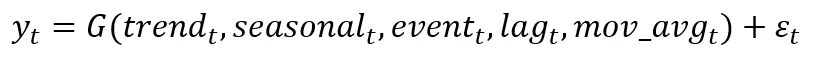

Where:

- *y_t* is the forecasted transformed sales at time *t*, where *y_t = f(sales_t)* and *f(⋅)* is a transformation function (e.g., `log⁡(⋅)`, `sqrt()`, `logistic()`).
- *G(⋅)* represents a machine learning algorithm (such as linear regression, LightGBM, XGBoost, or Random Forest).
- *trend_t* is the trend component at time t.
- *seasonal_t* is the dummy variable (e.g., weekday, month, weekend flag).
- *event_t* is the event component (e.g., holidays, promotions, special events).
- *lag_t* is the lagged sales values (e.g., sales at n = 1, 2, lag orders, etc.).
- *mov_avg_t* is the moving average of sales over a specified window.
- *ϵ_t* is the noise or error term.

##### Import libraries

In [ ]:
#!pip install -q numpy pandas matplotlib 
#!pip install -q statsmodels scikit-learn
!pip install -q lightgbm xgboost

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.metrics import mean_absolute_error, mean_squared_error

from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold,KFold
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Set random seed for reproducibility
np.random.seed(42)
cal = USFederalHolidayCalendar()

import warnings
warnings.filterwarnings('ignore')

##### Data Loading and Preprocessing

In [ ]:
file = '../../data/Electric_Production.csv'
df = pd.read_csv(file)
df.columns = ['date', 'sales']
df = df.sort_values(['date'])

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['sales'], label='Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Data')
plt.legend()
plt.show()

##### Feature Engineering

In [ ]:
def create_date(df, x, lag_n):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['weekday'] = df['date'].dt.day_name()
    df['month'] = df['date'].dt.month_name()

    df = pd.get_dummies(df, columns=['weekday', 'month'], prefix='is')
    
    holidays = cal.holidays(start=df['date'].min(), end=df['date'].max())
    df['is_holiday'] = df['date'].isin(holidays).astype(int)
    
    df['t'] = (df['date'] - df['date'].min()).dt.days
    df['t_lg'] = np.log1p(df['t'])
    
    for lag in range(1, lag_n + 1):
        df[f'lag{lag}'] = df[x].shift(lag)
    
    df['rolling_mean_7'] = df[x].rolling(window=7).mean()
    df['rolling_std_7'] = df[x].rolling(window=7).std()
    df['rolling_mean_30'] = df[x].rolling(window=30).mean()
    df['rolling_std_30'] = df[x].rolling(window=30).std()
    
    df = df.fillna(0)
    return df

In [ ]:
new_df = create_date(df, 'sales', 3)

In [ ]:
## Original dataset 
df.head()

In [ ]:
## New dataset with new date-based columns
new_df.head()

##### Transformation Functions

In [ ]:
max_y = new_df['sales'].max()

In [ ]:
def transform_target(y, transform_fun):
    if transform_fun == 'log':
        return np.log(y)
    elif transform_fun == 'sqrt':
        return np.sqrt(y)
    elif transform_fun == 'logistic':
        return 1 / (1 + np.exp(-y/max_y))
    else:
        raise ValueError("Unsupported transformation function. Choose from 'log', 'sqrt', 'logistic'.")

def inverse_transform_target(y, transform_fun):
    if transform_fun == 'log':
        return np.exp(y)
    elif transform_fun == 'sqrt':
        return np.square(y)
    elif transform_fun == 'logistic':
        return -np.log((1 / y) - 1)*max_y
    else:
        raise ValueError("Unsupported transformation function. Choose from 'log', 'sqrt', 'logistic'.")

##### Model Training

In [ ]:
def train_ml_model(X_train, y_train, X_valid, y_valid, model_type='lightgbm', transform_fun=None):
    if transform_fun is not None:
        y_train = transform_target(y_train, transform_fun)
        y_valid = transform_target(y_valid, transform_fun)
    if model_type == 'lightgbm':
        train_data = lgb.Dataset(X_train, label=y_train)
        valid_data = lgb.Dataset(X_valid, label=y_valid)
        params = {'objective': 'regression', 'metric': 'rmse', 'verbosity': -1}
        model = lgb.train(params=params, train_set=train_data, valid_sets=[valid_data], num_boost_round=300, callbacks=[lgb.early_stopping(stopping_rounds=3)])
    elif model_type == 'xgboost':
        model = xgb.XGBRegressor(objective='reg:linear', n_estimators=150)
        model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_valid, y_valid)], verbose=False)
    elif model_type == 'linear_regression':
        model = LinearRegression()
        model.fit(X_train, y_train)
    elif model_type == 'random_forest':
        model = RandomForestRegressor(n_estimators=150)
        model.fit(X_train, y_train)
    else:
        raise ValueError("Unsupported model type. Choose from 'lightgbm', 'xgboost', 'linear_regression', 'random_forest'.")
    return model

##### Feature Selection

In [ ]:
def getcorr_cut(Y, df, varnamelist, thresh):
    corr = []
    meanv = []
    for vname in varnamelist: 
        X = df[vname]              
        C = np.corrcoef(X, Y)      
        beta=np.round(C[1, 0],4)
        corr.append(beta) 
        avg = round(X.mean(), 6)
        meanv.append(avg) 
    corrdf = pd.DataFrame({'varname': varnamelist, 'correlation': corr, 'mean': meanv})
    corrdf['abscorr'] = np.abs(corrdf['correlation'])
    corrdf.sort_values(['abscorr'], ascending=False, inplace=True)
    corrdf['order'] = range(1,len(corrdf)+1)
    corrdf['meanabs'] = np.abs(corrdf['mean']) 
    corrdf['abscorr'] = corrdf['abscorr'].fillna(0.0)
    corrdf = corrdf[(corrdf.abscorr >= thresh)]
    return corrdf

In [ ]:
df = new_df.copy()
features = list(df.columns)
rem = ['date','sales']
for itv in rem:
    features.remove(itv)

In [ ]:
X = df[features]
y = df['sales']
cor_df = getcorr_cut(y, X, features, 0.05)
features = list(cor_df.varname)
X = df[features]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)

##### Rolling Window Validation

In [ ]:
# Use backtesting to sequentially test the model
def rolling_window_validation(DF, target_col, lag_n, train_size, test_size, features, model_type='lightgbm', transform_fun=None):
    predictions = []
    actuals = []
    test_indices = []
    # You can start testing from other points
    for start in range(0, len(DF) - train_size - test_size + 1, test_size):
        train = DF[start:start + train_size]
        test = DF[start + train_size:start + train_size + test_size]
        test_indices.extend(test.index)
        X_train = train.drop(columns=[target_col, 'date'])
        y_train = train[target_col]
        X_test = test.drop(columns=[target_col, 'date'])
        y_test = test[target_col]
        X_train = X_train[features]
        X_test = X_test[features]
        model = train_ml_model(X_train, y_train, X_test, y_test, model_type=model_type, transform_fun=transform_fun)
        y_pred = model.predict(X_test)
        if transform_fun is not None:
            y_pred = inverse_transform_target(y_pred, transform_fun)
        predictions.extend(y_pred)
        actuals.extend(y_test)

    # Use MAPE % to represent the error term 
    mape_rt = mean_absolute_percentage_error(actuals, predictions)
    return predictions, actuals, test_indices, model, mape_rt

In [ ]:
# Perform rolling window validation
train_size = 340
test_size = 50
predictions, actuals, test_indices, model, mape_rt = rolling_window_validation(new_df,
                                                                               'sales',
                                                                               3,
                                                                               train_size,
                                                                               test_size,
                                                                               features,
                                                                               model_type='linear_regression',
                                                                               transform_fun='logistic'
                                                     )

##### Forecasting the Next Day’s Sales

In [ ]:
def forecast_next_1_day(model, DF, features):
    # Ensure the data frame is sorted by date
    df = df.sort_values('date')

    # Create the next day's date
    next_date = df['date'].max() + pd.Timedelta(days=1)

    # Create a new row for the next day's features
    new_row = pd.DataFrame(index=[0])

    # Fill the new row with feature values
    new_row['date'] = next_date
    new_row['t'] = (next_date - df['date'].min()).days
    new_row['t_lg'] = np.log(new_row['t'] + 1)

    # Calculate lag features
    for lag in range(1, 4):  # Assuming lag_n=3 from the provided create_date function
        new_row[f'lag{lag}'] = df['sales'].shift(lag).iloc[-1]

    # Calculate rolling statistics
    new_row['rolling_mean_7'] = df['sales'].rolling(window=7).mean().iloc[-1]
    new_row['rolling_std_7'] = df['sales'].rolling(window=7).std().iloc[-1]
    new_row['rolling_mean_30'] = df['sales'].rolling(window=30).mean().iloc[-1]
    new_row['rolling_std_30'] = df['sales'].rolling(window=30).std().iloc[-1]

    # Extract day of the week and month for dummy variables
    new_row['weekday'] = next_date.day_name()
    new_row['month'] = next_date.month_name()

    dummies_wkd = pd.get_dummies(new_row['weekday'], prefix='is')
    new_row = pd.concat([new_row, dummies_wkd], axis=1)

    dummies_mon = pd.get_dummies(new_row['month'], prefix='is')
    new_row = pd.concat([new_row, dummies_mon], axis=1)

    holidays = cal.holidays(start=df['date'].min(), end=df['date'].max())
    new_row['is_holiday'] = next_date in holidays

    # Fill missing dummy variables with 0 if they do not exist
    missing_columns = set(features) - set(new_row.columns)
    for col in missing_columns:
        new_row[col] = 0

    # Ensure the new row contains only the required features
    new_row = new_row[features + ['date']]

    # Predict the sales for the next day
    sales_prediction = model.predict(new_row[features])[0]

    return sales_prediction, new_row

##### Forecasting the Next 7 Days’ Sales

In [ ]:
def forecast_next_7_days(model, df, features):
    predictions = []
    for _ in range(7):
        sales_prediction, new_row = forecast_next_1_day(model, df, features)
        predictions.append(sales_prediction)

        # Append the prediction to the DataFrame to update lags and rolling stats for the next iteration
        new_row['sales'] = sales_prediction
        df = pd.concat([df, new_row[['date', 'sales'] + features]], ignore_index=True)

    return predictions, df

##### Applying the Forecasting Function

In [ ]:
# Predict the next 7 days' sales and update the DataFrame
df = new_df.copy()
seven_day_preds, updated_df = forecast_next_7_days(model, df, features)

##### Integrating Predictions with Historical Data

In [ ]:
# Add the 'pred' column for testing data predictions
new_df['pred'] = np.nan
new_df.loc[test_indices, 'pred'] = predictions

# Add the new forecasted sales data to new_DF
forecast_dates = pd.date_range(start=new_df['date'].max() + pd.Timedelta(days=1), periods=7)
forecast_df = pd.DataFrame({'date': forecast_dates, 'pred': seven_day_preds, 'sales': [np.nan] * 7})
new_df = pd.concat([new_df, forecast_df], ignore_index=True)

# Display the updated DataFrame with predictions
print(new_df.tail(15))

new_df[new_df.pred.isnull() == False][['date', 'sales', 'pred']].head(100)
new_df[new_df.pred.isnull() == False][['date', 'sales', 'pred']].tail(20)

##### Visualization

In [ ]:
# Plot 1: Time series plot with training and testing data
plt.figure(figsize=(14, 7))
plt.scatter(new_DF['date'][:train_size], new_DF['sales'][:train_size], color='blue', label='Training Data', alpha=0.6)
plt.scatter(new_DF['date'][train_size:train_size + test_size], new_DF['sales'][train_size:train_size + test_size], color='blue', label='Actual Testing Data', alpha=0.6)
plt.scatter(new_DF['date'][train_size:train_size + test_size], new_DF['pred'][train_size:train_size + test_size], color='red', label='Predicted Testing Data', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Training and Testing Data')
plt.legend()
plt.show()

# Plot 2: Last 25 points in current data and next 7 days forecasted sales
plt.figure(figsize=(14, 7))
last_25_data = new_DF[-(25 + 7):-7]
forecast_data = new_DF[-7:]

plt.scatter(last_25_data['date'], last_25_data['sales'], color='blue', label='Last 25 Days', alpha=0.6)
plt.plot(forecast_data['date'], forecast_data['pred'], color='red', linestyle='-', linewidth=1, marker='o', label='Next 7 Days Forecast', alpha=0.6)

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Last 25 Days and Next 7 Days Forecast')
plt.legend()
plt.show()